# Unitary and open dynamics of a spin-1/2 system using QuTiP

We consider the dynamics of a generic spin-1/2 system (or *two-level system*, *qubit*) generated by some interaction Hamiltonian, with and without the effect of a noisy environment causing decoherence.

We will use arbitrary units and set $\hbar\equiv1$

## Import modules and packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from tools import is_psd_dm

## Hamiltonian

Set up the bare (or *internal*) Hamiltonian of the system as

$H_0 = \frac{\omega_0}{2}\sigma_z$, where $\sigma_x,\sigma_y,\sigma_z$ are the [Pauli matrices](https://en.wikipedia.org/wiki/Pauli_matrices).

Alternatively, pick any time-independent Hamiltonian of your choice.

In [2]:
# energy gap between ground and excited states
w0 = 1

# Pauli matrices using QuTiP
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()

# bare Hamiltonian
H0 = (w0 / 2) * sz

## State vector

Calculate the ground ($g$) and excited ($e$) states of the bare Hamiltonian. If you picked $H_0=\omega_0\sigma_z/2$ you should get:

- $H_0|g\rangle = -\frac{\omega_0}{2}|g\rangle$
- $H_0|e\rangle = +\frac{\omega_0}{2}|e\rangle$

Construct any state $|\psi\rangle$ of your choice and calculate its energy $E$ with respect to $H_0$,
- $|\psi\rangle = c_g|g\rangle + c_e|e\rangle$, with $c_g^2+c_e^2 = 1$
- $E = \langle \psi|H_0|\psi\rangle$

In [3]:
# sorted eigenstates and eigenvectors using QuTiP
evals, evecs = H0.eigenstates()

# ground state |g> is evecs[0], excited |e> is evecs[1]

# coefficients
cg, ce = 1j, 2

# state vector
psi = cg * evecs[0] + ce * evecs[1]
psi = psi.unit()  # normalize

# energy
E = qt.expect(H0, psi)
print('Energy E =', E)

Energy E = 0.3


## Density operator

Represent the state $|\psi\rangle$ as a density operator and calculate the expectation value of the following hermitian operator (associated with some observable) $O = \sigma_y$

- from $|\psi\rangle \to \rho = |\psi\rangle\langle\psi|$
- expectation value as $\langle O\rangle  = \mathrm{Tr}[O\rho]$

Check if $\rho$ is a state by testing the three properties of density operators:
1. Unit trace: $\mathrm{Tr}[\rho]=1$
2. Self adjoint: $\rho^\dagger=\rho$
3. Positive semi-definite: $\rho >0$

In [4]:
# density operator from state vector
rho = psi * psi.dag()

# expectation value
O = sy
expO = qt.expect(O, rho)
print('<O> =', expO)

# check if it is a state
print('unit trace:', np.isclose(rho.tr(), 1.0))
print('self-adjoint:', rho.isherm)
print('positive semi-definite:', is_psd_dm(rho))

<O> = 0.7999999999999999
unit trace: True
self-adjoint: True
positive semi-definite: True


## Bloch representation

Any qubit density operator $\rho$ can be represented as a vector in a real 3D vector space $\vec{r} = (r_x,r_y,r_z)$ as:

$\rho =  \frac{\mathbb{1}+\vec{r}\cdot\vec{\sigma}}{2}$,

where $\vec{\sigma} = (\sigma_x,\sigma_y,\sigma_z)$ is a symbolic vector of Pauli operators. This is called the [Bloch representation](https://en.wikipedia.org/wiki/Bloch_sphere). The vector $\lVert\vec{r}\rVert \leq 1$ belongs to a ball of radius 1 called the Bloch ball, whose surface (the Bloch sphere) contains only pure states and whose interior contains only mixed states.

- Calculate the expectation value of all three Pauli operators $\sigma_x,\sigma_y,\sigma_z$
- Group the expecation values into the Bloch vector $\vec{r} = (r_x,r_y,r_z)$, with $r_k = \langle\sigma_k\rangle$.
- Represent the state on the Bloch-sphere using QuTiP's Bloch class

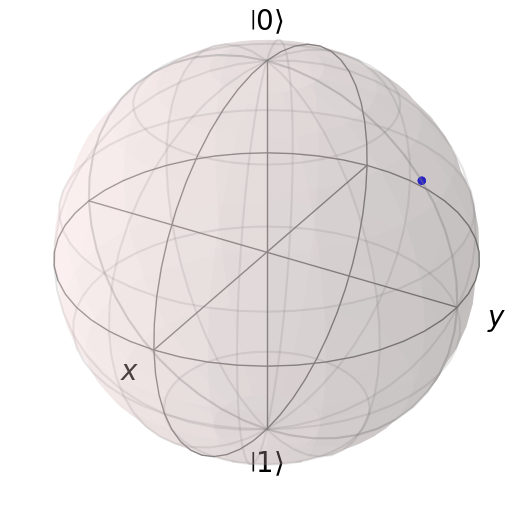

In [5]:
# Bloch vector
r = [qt.expect(sx, rho), qt.expect(sy, rho), qt.expect(sz, rho)]

# Bloch sphere
b = qt.Bloch()
b.add_points(np.array(r).reshape(3, 1))
b.show()

## Purity and entropy

Calculate:

- the purity $\mathcal{P}[\rho] = \mathrm{Tr}[\rho^2]$, and
- the von Neumann entropy $S[\rho] = \mathrm{Tr}[\rho\log\rho]$

In [6]:
# purity
purity = rho.purity()
print('purity =', purity)

# von Neumann entropy
S = qt.entropy_vn(rho)
print('entropy =', S)

purity = 0.9999999999999998
entropy = 5.024617682715035e-16


## Unitary dynamics

Calculate the unitary dynamics generated by some time-independent Hamiltonian $H = H_0 + H_1$ of your choice.

Then, propagate the initial state $\rho$ and study the time-dependent expectation value of some operator $O$.

Use QuTiP's sesolve for state evolution.

/home/leopold/miniconda3/envs/redfield/lib/python3.13/site-packages/qutip/solver/solver_base.py:583: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Text(0, 0.5, '<O(t)>')

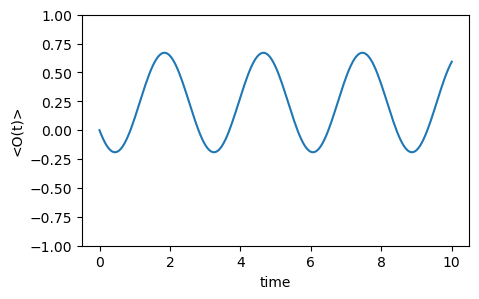

In [8]:
# driving frequency
w1 = 2.

# interaction Hamiltonian
H1 = (w1 / 2) * sx

# total Hamiltonian
H = H0 + H1

# time span
t0, tf = 0, 10
steps = 200
times = np.linspace(t0, tf, steps)

# observable
O = sx

# solve for expectation values
result = qt.sesolve(H, psi, times, [O], options={"store_states": True})
Ot = result.expect[0]

# plot
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(times, Ot)
ax.set_ylim([-1,1])
ax.set_xlabel('time')
ax.set_ylabel('<O(t)>')

### Dynamics on the Bloch sphere

Represent the dynamics on the Bloch sphere.

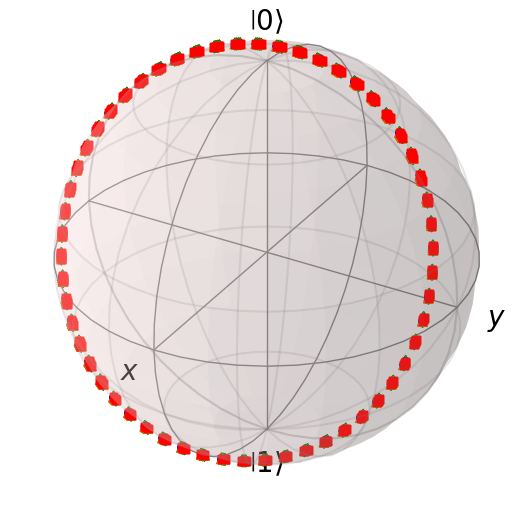

In [18]:
# get states at each time
states = result.states

# Bloch vectors
bloch_vectors = []
for state in states:
    bloch_vectors.append([qt.expect(sx, state), qt.expect(sy, state), qt.expect(sz, state)])
# Bloch sphere
#b = qt.Bloch()
b.add_points(np.real(np.array(bloch_vectors)).T)
b.show()

## Decoherence

Now consider a system affected by decoherence. We model spin flips at rate $\gamma$ using Lindblad operators.

Use QuTiP's mesolve for master equation dynamics.

/home/leopold/miniconda3/envs/redfield/lib/python3.13/site-packages/qutip/solver/solver_base.py:583: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Text(0, 0.5, '<O(t)>')

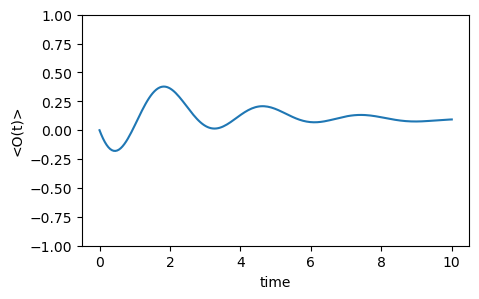

In [19]:
# rate
gamma = 0.2

# collapse operators
c_ops = [np.sqrt(gamma) * sx]

# solve master equation
result_decoh = qt.mesolve(H, rho, times, c_ops, [O], options={"store_states": True})
Ot_decoh = result_decoh.expect[0]

# plot
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(times, Ot_decoh)
ax.set_ylim([-1,1])
ax.set_xlabel('time')
ax.set_ylabel('<O(t)>')

### Dynamics on the Bloch sphere

Decoherence dynamics on the Bloch sphere.

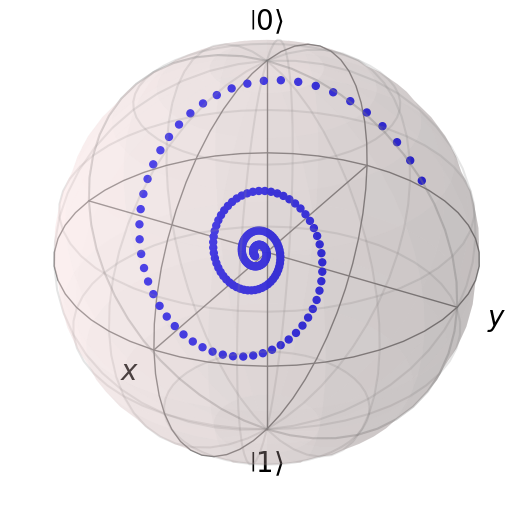

In [20]:
# get states
states_decoh = result_decoh.states

# Bloch vectors
bloch_vectors_decoh = np.real(np.array([[qt.expect(sx, state), qt.expect(sy, state), qt.expect(sz, state)] for state in states_decoh]))

# Bloch sphere
b = qt.Bloch()
b.add_points(bloch_vectors_decoh.T)
b.show()